In [1]:
import numpy as np
import numpy.ma as ma
import scipy as sp
import scipy.optimize as opt
from scipy import interpolate 
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import scipy.integrate as integ
import scipy.optimize as opt
from scipy.optimize import curve_fit
import pandas as pd
import math
import astropy
from astropy.cosmology import FlatLambdaCDM
import astroquery
from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm 
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = 12,8
#%matplotlib inline
import os, sys
import scipy.integrate as integ
# import george
# from george import kernels
# from george.kernels import ExpSquaredKernel
# from george.kernels import Matern32Kernel
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
# # from pysynphot import observation
# # from pysynphot import spectrum

# from astropy.modeling import models
# from astropy import units as u
# import specutils
# from specutils import Spectrum1D, SpectralRegion
# from specutils.fitting import fit_lines
# from specutils.manipulation import extract_region
# from specutils.fitting import fitmodels 
# # from specutils.fitting.fitmodels import estimate_line_parameters
# from specutils.manipulation import extract_region
# from specutils.analysis import centroid, fwhm
# from specutils.fitting.continuum import fit_continuum


cwd=os.getcwd()
cosmo = FlatLambdaCDM(H0=67.7, Om0=0.307)

CGS_H=6.6260755e-27
CGS_C=2.99792458e10
CGS_K=1.380658e-16

In [2]:
def manglemin(params,SED,data_in,lim):

    MangledSpec = SED
    paramlist = np.array([params[key].value for key in params.keys()]) 
    Weights= np.append(np.append(data_in["weights"].iloc[0], paramlist), data_in["weights"].iloc[-1])
    SplObj = interpolate.CubicSpline(data_in["lambda_eff"],Weights)#,bc_type='clamped')
    MangledSpec_flux = MangledSpec['Flux'] * SplObj(MangledSpec['Wave'])
    specflux= np.array([np.trapz(np.interp(FILTER[0],MangledSpec['Wave'],MangledSpec_flux)*FILTER[1],x=FILTER[0])/np.trapz(FILTER[1],FILTER[0]) for FILTER in data_in['FILTER'].iloc[1:lim]])
    out=np.array((data_in["flux"].iloc[1:lim].values-specflux)**2)/(data_in["fluxerr"].iloc[1:lim].values**2)
    return out

def piv_llambda(FILTER):
    Wave2 = integ.trapz(FILTER[1]*FILTER[0],x=FILTER[0])/integ.trapz(FILTER[1],x=FILTER[0]) 
    return Wave2

In [3]:
filters=np.array(['u','g','r','i','z'])#'u',

lim=6

# u=18.79
u=22.839
g=22.339
r=22.283
i=22.401
z=22.60

err_u=0.1
err_g=0.02
err_r=0.02
err_i=0.03
err_z=0.05

loadfilts=[np.loadtxt('./2020neh/Filters/SDSS_u.dat',unpack=True),
           np.loadtxt('./2020neh/Filters/PS1_g_0.dat',unpack=True),
           np.loadtxt('./2020neh/Filters/PS1_r_0.dat',unpack=True),
           np.loadtxt('./2020neh/Filters/PS1_i_0.dat',unpack=True),
           np.loadtxt('./2020neh/Filters/PS1_z_0.dat',unpack=True)]

mags=np.array([u,g,r,i,z])
mags_errs=np.array([err_u,err_g,err_r,err_i,err_z])

spec=pd.read_csv('SN2019uit_host_spec.txt',delim_whitespace=True,skiprows=0,names=['Wave','Flux']) 

# spec=pd.read_csv('2019uit-LRIS-2020-02-16.csv',delimiter=',',skiprows=20,names=['Wave','Flux','FluxErr']) 

print(spec)
# spec_fluxes= np.array([np.trapz(np.interp(FILTER[0],spec['Wave'],spec['Flux'])*FILTER[1],x=FILTER[0])/np.trapz(FILTER[1],FILTER[0]) for FILTER in loadfilts])
spec_flux_err=spec['Flux']*0.1

filt_flux=[]
filt_flux_err=[]
for a,b,c in zip(mags,mags_errs,loadfilts):
    x=(3631*(10**(a/-2.5)))/((3.34*(10**4))*(piv_llambda(c)**2))
    filt_flux.append(x)
    filt_flux_err.append((b*x)/1.09)
    
# filt_flux=np.array(filt_flux)    
# filt_flux_err=np.array(filt_flux_err)




             Wave          Flux
0     3800.000000  5.711260e-16
1     3803.383214  9.267720e-16
2     3806.766428  1.068876e-15
3     3810.149642  6.911942e-16
4     3813.532856  6.106416e-16
...           ...           ...
1533  8986.467057  1.512636e-16
1534  8989.850271  1.600713e-16
1535  8993.233485  1.853834e-16
1536  8996.616699  1.711444e-16
1537  8999.999913  1.539527e-16

[1538 rows x 2 columns]


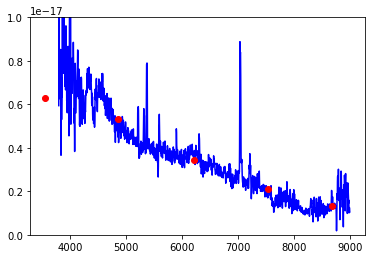

In [6]:
SED=spec

d = {'flux': filt_flux,'fluxerr': filt_flux_err,'FILTER': loadfilts}
data= pd.DataFrame(data=d)
data['spec_filtflux'] = np.array([np.trapz(np.interp(FILTER[0],SED['Wave'],SED['Flux'])*FILTER[1],x=FILTER[0])/np.trapz(FILTER[1],FILTER[0]) for FILTER in data['FILTER']])
data['lambda_eff']=np.array([piv_llambda(FILTER) for FILTER in data['FILTER']])


anchor_min_wavelength = data['FILTER'].iloc[0][0].min() - 5000
dx_l = piv_llambda(data['FILTER'].iloc[1]) - piv_llambda(data['FILTER'].iloc[0])
dy_l = data['flux'].iloc[1] - data['flux'].iloc[0]
m_lower = dy_l / dx_l
c_lower = data['flux'].iloc[0] - m_lower * piv_llambda(data['FILTER'].iloc[0])
anchor_max_wavelength = data['FILTER'].iloc[-1][0].max() + 5000
dx_u = piv_llambda(data['FILTER'].iloc[-1]) - piv_llambda(data['FILTER'].iloc[-2])
dy_u = data['flux'].iloc[-1] - data['flux'].iloc[-2]
m_upper = dy_u / dx_u
c_upper = data['flux'].iloc[-1] - m_upper * piv_llambda(data['FILTER'].iloc[-1])
spline_wav=np.array([piv_llambda(Filter) for Filter in data['FILTER']])
spline_fit_wav=np.append(np.append(anchor_min_wavelength,spline_wav),anchor_max_wavelength)

d1 = {'flux': [anchor_min_wavelength * m_lower + c_lower],'fluxerr': [np.nan],'FILTER': [np.nan], 'lambda_eff': [anchor_min_wavelength],'spec_filtflux': [anchor_min_wavelength * m_lower + c_lower]}
d1= pd.DataFrame(data=d1)
d2 = {'flux': [anchor_max_wavelength * m_upper + c_upper],'fluxerr': [np.nan],'FILTER': [np.nan], 'lambda_eff': [anchor_max_wavelength],'spec_filtflux': [anchor_max_wavelength * m_upper + c_upper]}
d2= pd.DataFrame(data=d2)
data_All= d1.append(data,ignore_index=True)
data_epoch=data_All.append(d2,ignore_index=True)
data_epoch.reset_index()
synthetic_flux = data_epoch.iloc[1:lim]['spec_filtflux'].values
obs_flux = data_epoch.iloc[1:lim]['flux'].values
obs_fluxerr = data_epoch.iloc[1:lim]['fluxerr'].values
wanted_filters = filters

if len(synthetic_flux) == len(obs_flux):
    params = Parameters()
    for i, flux_tuple in enumerate(zip(synthetic_flux, obs_flux,obs_fluxerr)):
        params.add(wanted_filters[i], value=((flux_tuple[0]/flux_tuple[1])))  #flux_tuple[0] / flux_tuple[1])
paramlist = np.array([params[key].value for key in params.keys()])
weights = np.append(np.append(1, paramlist), 1)
data_epoch["weights"]=weights

out_now = minimize(manglemin, params, args=(SED, data_epoch,lim))
outparamlist = np.array([out_now.params[key].value for key in out_now.params.keys()])
finalweights= np.append(np.append(data_epoch["weights"].iloc[0], outparamlist), data_epoch["weights"].iloc[-1]) 
final_spl = interpolate.CubicSpline(spline_fit_wav, finalweights,)#bc_type='clamped')
mS_flux = (SED['Flux']*final_spl(SED['Wave']))  


plt.plot(SED['Wave'],SED['Flux'],'k-')
plt.plot(SED['Wave'],mS_flux,'b-')
plt.plot(data['lambda_eff'],obs_flux,'ro')
plt.ylim([0,0.1e-16])


np.savetxt('SN2019uit_host_mangled_spec2.txt',np.vstack([SED['Wave'],mS_flux,0.1*mS_flux]).T,fmt='%s',delimiter=',')